<h2> Implementation of Flow-based Difference of Guassian (FDoG) </h2>

Dσ,k,τ(x) = Gσ(x) − τ · Gkσ(x) <br>
and then we use a thresholding function on the dog output <br>
Made the thresholding function separate so that we can change it independently of the DoG function<br>
<b>INPUT SHOULD BE GREYSCALE</b>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def conv2D(img,kernel):
    h,w = img.shape[0:2]
    k = kernel.shape[0]
    padding = int(k/2)
    
    # padded = np.zeros((h + padding*2, w + padding*2)) #extra zeroes so that kernel fits properly
    # padded[padding:h+padding,padding:w+padding] = img[:,:,0] #setting everything except the padding to be equal to image
    
    padded = np.pad(img,int(k/2), 'constant', constant_values=(0))
    output = np.zeros((h,w))
    for i in range(padding, h+padding):
        for j in range(padding, w+padding):
            # print(padded[j-padding: j+padding+1, i-padding: i+padding+1])
            output[i - padding,j-padding] = (kernel * padded[i-padding: i+padding+1, j-padding: j+padding+1]).sum()
    
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output

def sobelFilter(img):
    #img = img[:,:,0]
    gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) 
    gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
    ex = conv2D(img,gx)
    ey = conv2D(img,gy)
    return [ex,ey]

(1899, 1833)


Text(0.5, 1.0, 'SST')

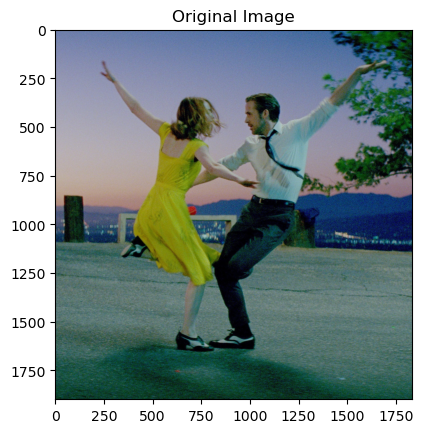

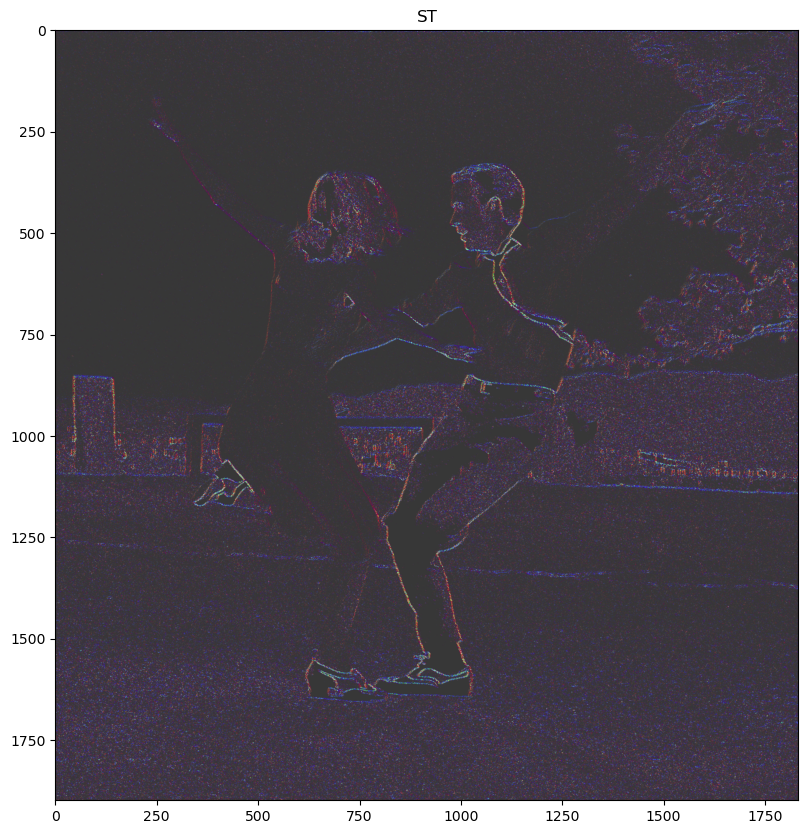

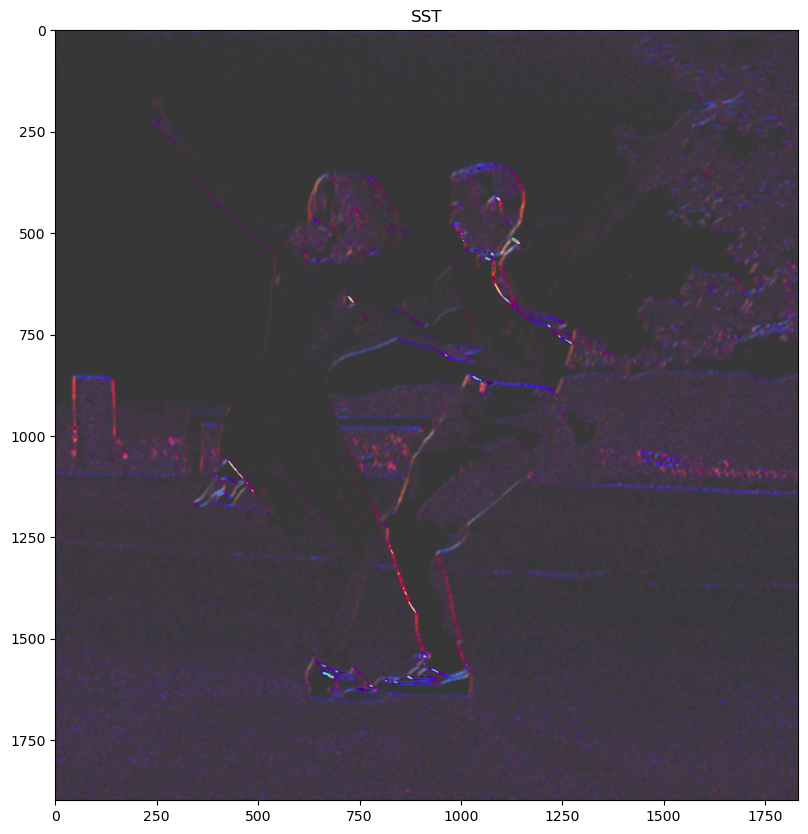

In [77]:
img = cv2.imread("lala_land.jpg")
plt.figure()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original Image")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Dx = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
Dy = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)

#[Dx, Dy] = sobelFilter(img)
print(Dx.shape)
ST = np.stack((Dx*Dx,Dx*Dy,Dy*Dy),axis = 2)

ST = (ST - ST.min()) / (ST.max() - ST.min())
# Multiply by 255 to scale back to [0, 255] range for integer display
ST = (ST * 255).astype(np.uint8)

sigma_c =2.4

SST = cv2.GaussianBlur(ST, (0, 0), sigma_c)
plt.figure(figsize=(10,10))
plt.imshow(ST*9)
plt.title("ST")

plt.figure(figsize=(10,10))
plt.imshow(SST*9)
plt.title("SST")


In [13]:
import cv2
import numpy as np

def ETF(image, window_size):
    image = np.double(image)
    maxi = np.max(image)
    image = image / maxi

    # Applying Gaussian blurring to reduce noise
    sigma_blur = 2
    filter_size_blur = int(np.ceil(3 * sigma_blur + 4))
    gauss1 = cv2.getGaussianKernel(filter_size_blur, sigma_blur) @ cv2.getGaussianKernel(filter_size_blur, sigma_blur).T

    # Compute Gaussian filter
    blurred_image = cv2.filter2D(image, -1, gauss1)

    # Gradient computation using Sobel filter
    Gx, Gy = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3), cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    G = np.sqrt(Gx**2 + Gy**2)
    G_norm = G / np.max(G)

    G[G == 0] = 1

    # Vectors perpendicular to the gradient (local tangential direction)
    tx = (-1 * Gy) / G
    ty = Gx / G

    # Stacking these two (tx and ty) gives the tangent vector at that particular pixel
    m, n = tx.shape

    for i in range(m):
        for j in range(n):
            # Extract local window
            i_min = max(0, i - window_size // 2)
            i_max = min(m, i + window_size // 2 + 1)
            j_min = max(0, j - window_size // 2)
            j_max = min(n, j + window_size // 2 + 1)

            # Calculate mean of the vectors in the window
            mean_tx = np.mean(tx[i_min:i_max, j_min:j_max])
            mean_ty = np.mean(ty[i_min:i_max, j_min:j_max])

            # Update vectors using mean
            tx[i, j] = mean_tx
            ty[i, j] = mean_ty
            
    # Normalize the vectors
    ETF_mag = np.sqrt(tx**2 + ty**2)
    ETF_mag[ETF_mag == 0] = 1
    tx /= ETF_mag
    ty /= ETF_mag

    # Stack tx and ty to create the output ETF image
    ETF_output = np.stack([tx, ty], axis=2)

    return ETF_output

def ETF_to_tangent(ETF_image, m, n):
    tangent_pg1 = np.zeros((m, n))
    tangent_pg1[(-1 <= ETF_image[:, :, 0]) & (ETF_image[:, :, 0] <= -np.sin(np.pi / 8))] = -1
    tangent_pg1[(-np.sin(np.pi / 8) < ETF_image[:, :, 0]) & (ETF_image[:, :, 0] <= np.sin(np.pi / 8))] = 0
    tangent_pg1[(np.sin(np.pi / 8) < ETF_image[:, :, 0]) & (ETF_image[:, :, 0] <= 1)] = 1

    tangent_pg2 = np.zeros((m, n))
    tangent_pg2[(-1 <= ETF_image[:, :, 1]) & (ETF_image[:, :, 1] <= -np.sin(np.pi / 8))] = -1
    tangent_pg2[(-np.sin(np.pi / 8) < ETF_image[:, :, 1]) & (ETF_image[:, :, 1] <= np.sin(np.pi / 8))] = 0
    tangent_pg2[(np.sin(np.pi / 8) < ETF_image[:, :, 1]) & (ETF_image[:, :, 1] <= 1)] = 1

    tangent = np.zeros_like(ETF_image)
    grad = np.zeros_like(ETF_image)
    tangent[:, :, 0] = tangent_pg1
    tangent[:, :, 1] = tangent_pg2
    grad[:, :, 0] = tangent_pg2
    grad[:, :, 1] = -tangent_pg1

    return tangent, grad


# Example usage:
# H_e_result = FDOG(image, ETF_image, sigma_c, rho, sigma_m, tau, sigma_blur, num_iter)
import numpy as np

def FDOG(image, tangent, grad, sigma_c, rho, sigma_m, tau):
    image = np.double(image)
    m, n, _ = tangent.shape
    print(m,n)
    # Calculate H_g at each pixel
    H_g = np.zeros((m, n))
    sigma_s = 1.6 * sigma_c

    for i in range(m):
        for j in range(n):
            total_wt = 0

            for k in range(-np.floor(4 * sigma_s).astype(int),(np.floor(4 * sigma_s).astype(int)) + 1):
                x = j + (k * grad[i, j, 0])
                y = i + (k * grad[i, j, 1])

                if x < 1:
                    continue
                elif x > n:
                    continue
                elif y < 1:
                    continue
                elif y > m:
                    continue
                    
                
                dist_sqrd = ((k * grad[i, j, 0]) ** 2) + ((k * grad[i, j, 1]) ** 2)
                wt = np.exp(-dist_sqrd / (2 * (sigma_c ** 2)))/sigma_c
                wt = wt - (rho * (np.exp(-dist_sqrd / (2 * (sigma_s ** 2)))/sigma_s))
                wt = wt / np.sqrt(2 * np.pi)
        
                H_g[i, j] = (H_g[i, j] + wt * image[int(y - 1), int(x - 1)]).astype(int)
                total_wt += wt

            H_g[i, j] = H_g[i, j]/total_wt
            
    H_e = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            x, y = j, i
            dist = 0
            wt = np.exp(-(dist ** 2) / (2 * sigma_m ** 2)) / (sigma_m * np.sqrt(2 * np.pi))
            H_e[i, j] += wt * H_g[y, x]
            total_wt = wt

            for k in range(1, np.floor(4 * sigma_m).astype(int) + 1):
                if (x >= n) or (y >= m):
                    continue
                    
                x_plus_tangent_0 = int(x + tangent[int(y), int(x), 0])
                y_plus_tangent_1 = int(y + tangent[int(y), int(x), 1])

                if x_plus_tangent_0 < 1:
                    continue
                elif x_plus_tangent_0 > n:
                    continue
                elif y_plus_tangent_1 < 1:
                    continue
                elif y_plus_tangent_1 > m:
                    continue
                    
                dist += np.sqrt(tangent[int(y), int(x), 0] ** 2 + tangent[int(y), int(x), 1] ** 2)
                wt = np.exp(-(dist ** 2) / (2 * sigma_m ** 2)) / (sigma_m * np.sqrt(2 * np.pi))
                H_e[i, j] += wt * H_g[y_plus_tangent_1 - 1, x_plus_tangent_0 - 1]
                total_wt += wt
                temp_x, temp_y = x, y
                x, y = temp_x + tangent[int(temp_y), int(temp_x), 0], temp_y + tangent[int(temp_y), int(temp_x), 1]

            x, y = j, i
            dist = 0
            for k in range(1, np.floor(4 * sigma_m).astype(int) + 1):
                if (x >= n) or (y >= m):
                    continue
                    
                x_plus_tangent_0 = int(x - tangent[int(y), int(x), 0])
                y_plus_tangent_1 = int(y - tangent[int(y), int(x), 1])

                if x_plus_tangent_0 < 1:
                    continue
                elif x_plus_tangent_0 > n:
                    continue
                elif y_plus_tangent_1 < 1:
                    continue
                elif y_plus_tangent_1 > m:
                    continue

                dist += np.sqrt(tangent[int(y), int(x), 0] ** 2 + tangent[int(y), int(x), 1] ** 2)
                wt = np.exp(-(dist ** 2) / (2 * sigma_m ** 2)) / (sigma_m * np.sqrt(2 * np.pi))
                H_e[i, j] += wt * H_g[int(y - tangent[int(y), int(x), 1] - 1), int(x - tangent[int(y), int(x), 0] - 1)]
                total_wt += wt
                temp_x, temp_y = x, y
                x, y = temp_x - tangent[int(temp_y), int(temp_x), 0], temp_y - tangent[int(temp_y), int(temp_x), 1]

            # Threshold
            if H_e[i, j] < 0 and (1 + np.tanh(H_e[i, j])) < tau:
                H_e[i, j] = 0
            else:
                H_e[i, j] = 1
    return H_e

# Example usage:
# H_e_result = FDOG_one_iter(image, tangent, grad, sigma_c, rho, sigma_m, tau)




1899 1833


/var/folders/zr/t9rc621d3jbds82pyx7m6n5w0000gn/T/ipykernel_35733/3912141023.py:117: RuntimeWarning: invalid value encountered in scalar divide
  H_g[i, j] = H_g[i, j]/total_wt


Text(0.5, 1.0, 'SST')

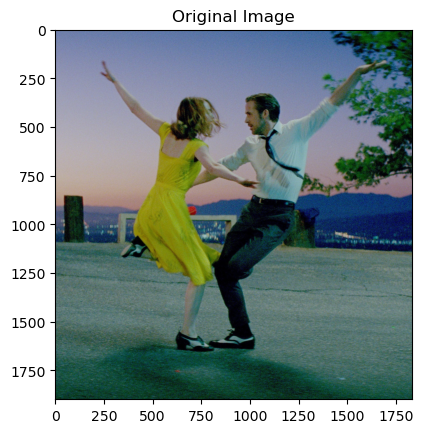

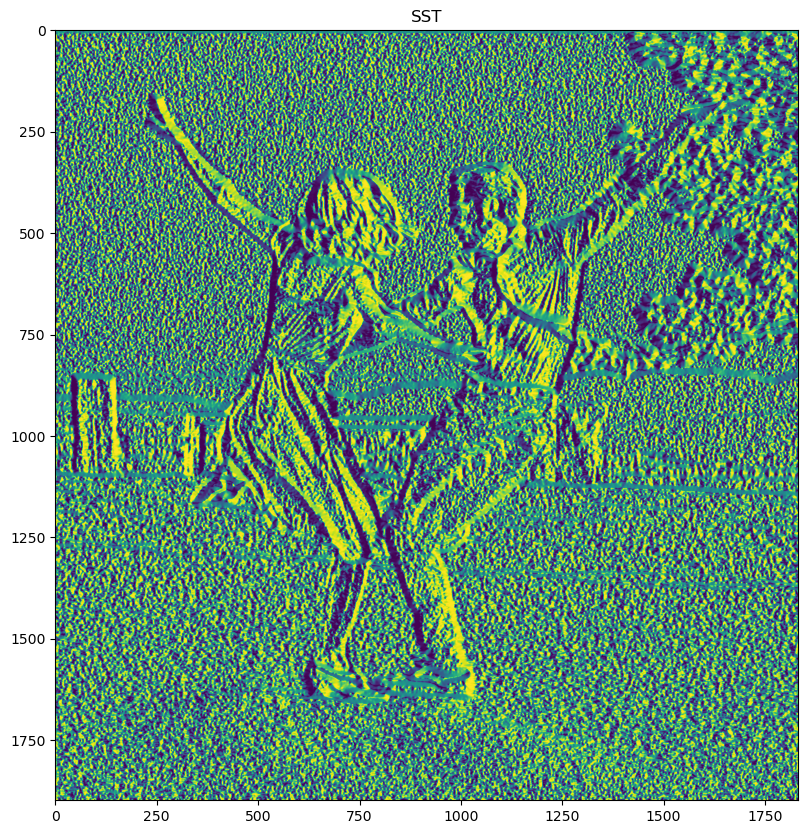

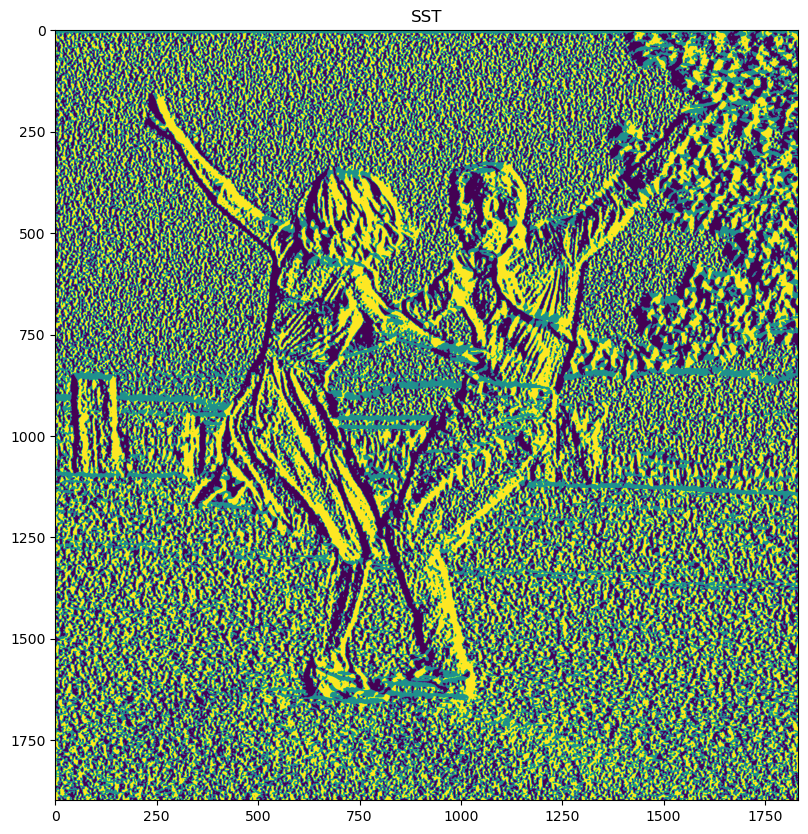

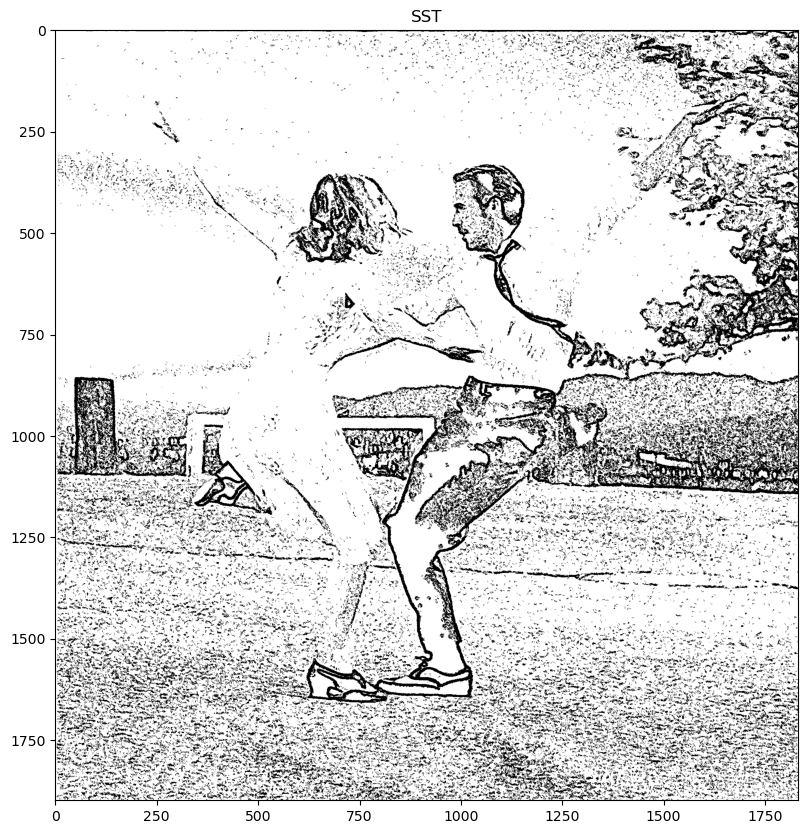

In [17]:
img = cv2.imread("lala_land.jpg")
plt.figure()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original Image")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

output = ETF(img,3)
plt.figure(figsize=(10,10))
plt.imshow(output[:,:,1])
plt.title("SST")

m = img.shape[0]
n = img.shape[1]
[tan,grad] = ETF_to_tangent(output,m,n)
plt.figure(figsize=(10,10))
plt.imshow(tan[:,:,1])
plt.title("SST")

result = FDOG(img, tan, grad, 1.6, 0.99, 1, 0.5)
plt.figure(figsize=(10,10))
plt.imshow(result,cmap="gray")
plt.title("SST")